In [ ]:
# prompt: !install shap =0.46.0

!pip install shap==0.46.0
!pip install -U scikit-learn shap xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


In [ ]:
#============================
#  Imports
#============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
#============================
#  Imports
#============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings("ignore")
shap.initjs()
from sklearn.svm import SVC

from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings("ignore")
shap.initjs()




Model: KNN
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.89      0.95      0.92      1404
             Basal-like 2 (BL2)       0.91      0.94      0.92      1502
Luminal Androgen Receptor (LAR)       0.96      0.87      0.91      2211
                Mesenchymal (M)       0.91      0.94      0.93      1939

                       accuracy                           0.92      7056
                      macro avg       0.92      0.92      0.92      7056
                   weighted avg       0.92      0.92      0.92      7056



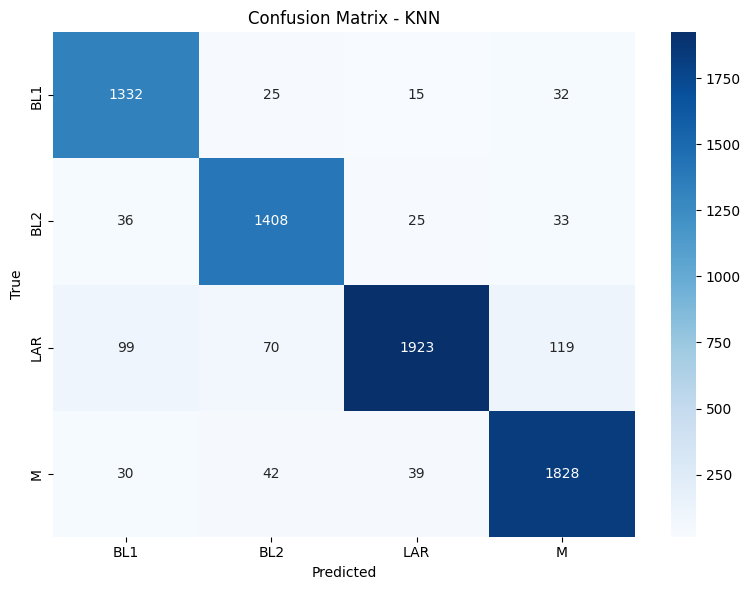

ROC-AUC Score: 0.9911


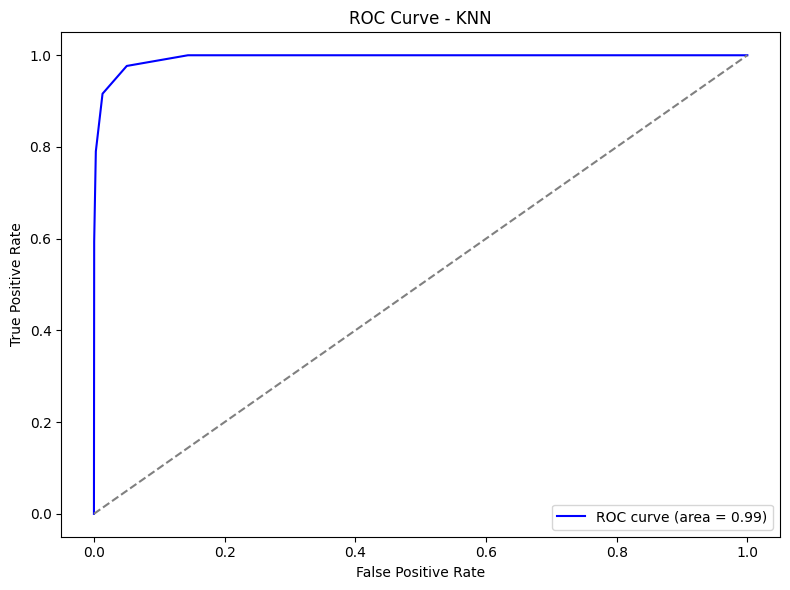

Accuracy: 91.99%

Model: SVM
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.74      0.81      0.77      1404
             Basal-like 2 (BL2)       0.76      0.65      0.70      1502
Luminal Androgen Receptor (LAR)       0.86      0.84      0.85      2211
                Mesenchymal (M)       0.78      0.84      0.81      1939

                       accuracy                           0.79      7056
                      macro avg       0.79      0.78      0.78      7056
                   weighted avg       0.79      0.79      0.79      7056



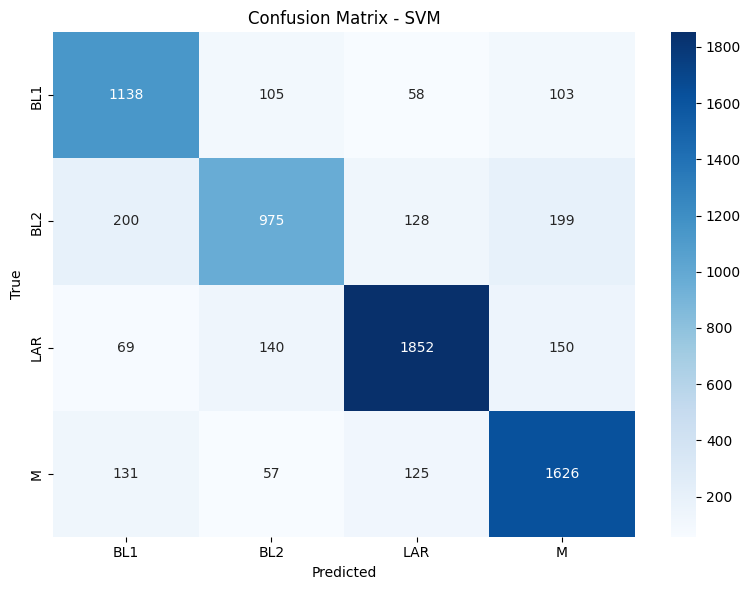

ROC-AUC Score: 0.9416


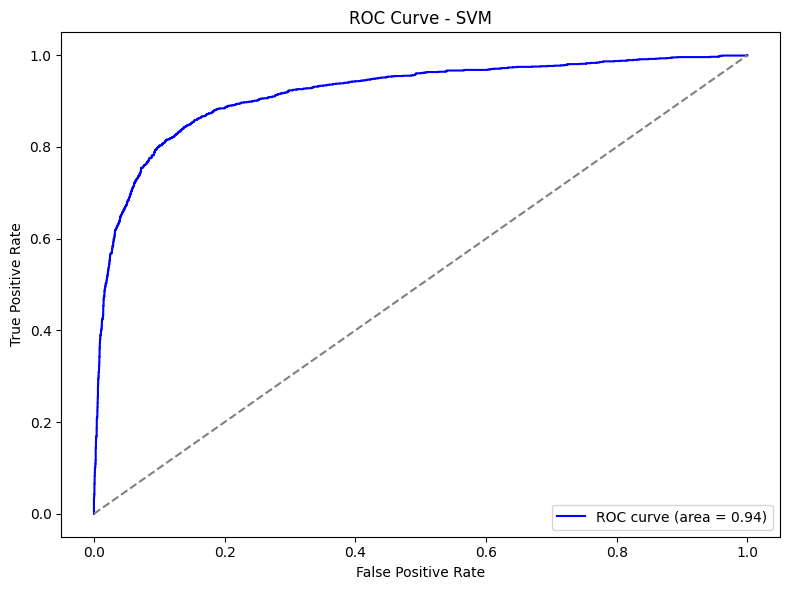

Accuracy: 79.24%

Model: XGBoost
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.89      0.86      0.88      1404
             Basal-like 2 (BL2)       0.87      0.85      0.86      1502
Luminal Androgen Receptor (LAR)       0.88      0.91      0.90      2211
                Mesenchymal (M)       0.89      0.90      0.89      1939

                       accuracy                           0.88      7056
                      macro avg       0.88      0.88      0.88      7056
                   weighted avg       0.88      0.88      0.88      7056



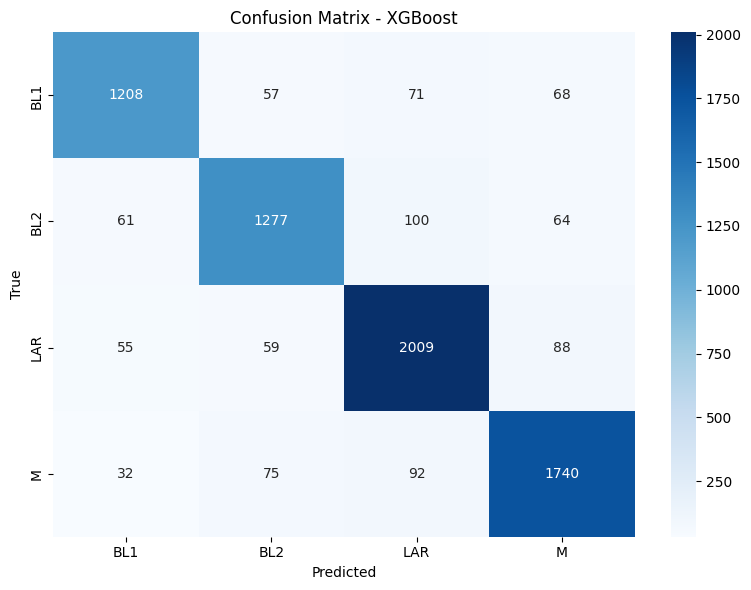

ROC-AUC Score: 0.9800


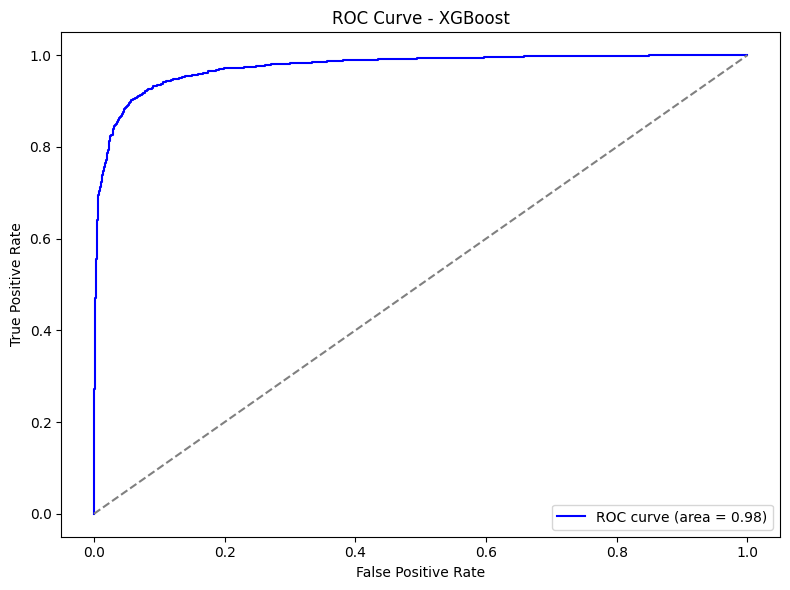

Accuracy: 88.35%

Model: Logistic Regression
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.76      0.78      0.77      1404
             Basal-like 2 (BL2)       0.77      0.62      0.69      1502
Luminal Androgen Receptor (LAR)       0.85      0.84      0.85      2211
                Mesenchymal (M)       0.75      0.85      0.80      1939

                       accuracy                           0.79      7056
                      macro avg       0.78      0.77      0.77      7056
                   weighted avg       0.79      0.79      0.78      7056



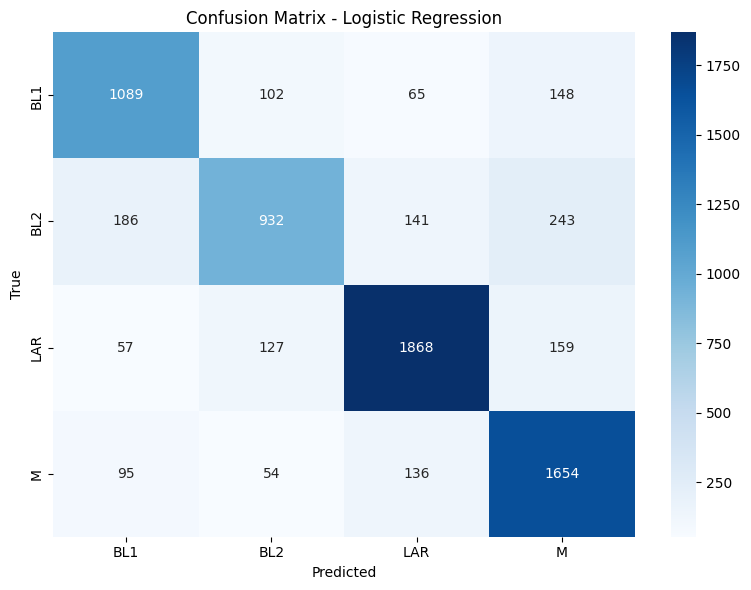

ROC-AUC Score: 0.9342


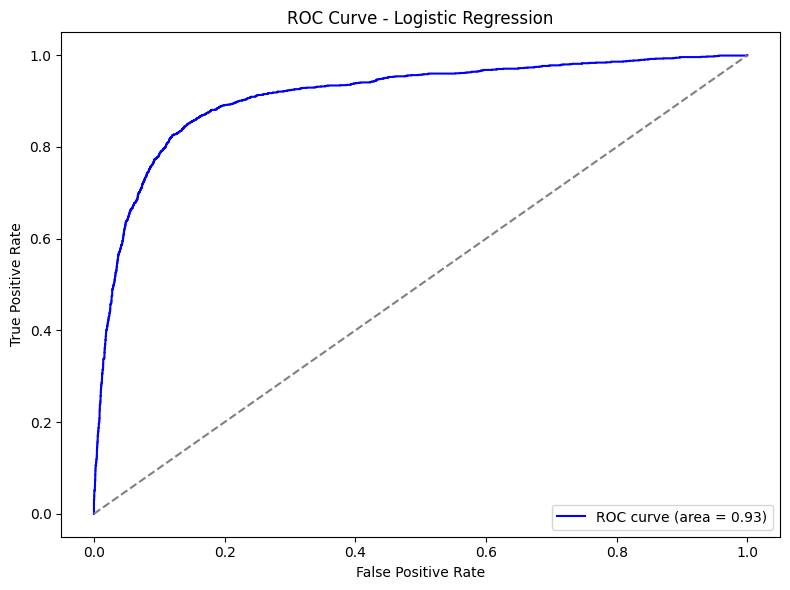

Accuracy: 78.56%
Best Model: KNN with Accuracy: 91.99%


In [ ]:
#============================
# Load and Prepare Data
#============================
df_metabolite = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_training_.csv")
X = df_metabolite.drop(columns=['TNBC_Subtype'])
y = df_metabolite['TNBC_Subtype']

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_labels = le.classes_

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Define Models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

#============================
# Model Evaluation
#============================
best_model = None
best_acc = 0
for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  # For ROC-AUC

    y_pred_labels = le.inverse_transform(y_pred)
    y_true_labels = le.inverse_transform(y_test)

    print(classification_report(y_true_labels, y_pred_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['BL1', 'BL2', 'LAR', 'M'], yticklabels=['BL1', 'BL2', 'LAR', 'M'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC-AUC Metric
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Model Accuracy
    acc = np.mean(y_pred == y_test)
    print(f"Accuracy: {acc * 100:.2f}%")

    if acc > best_acc:
        best_acc = acc
        best_model = (name, model)

print(f"Best Model: {best_model[0]} with Accuracy: {best_acc * 100:.2f}%")



##===Save Models for Comparabilty and Web App======

In [ ]:
import joblib

# Save each model individually
for name, model in models.items():
    filename = f'/content/drive/MyDrive/SAVED_MODELS/{name.replace(" ", "_")}_model.pkl'
    joblib.dump(model, filename)
    print(f"{name} model saved successfully!")


In [ ]:
background_data = shap.sample(X_train, 50)  # Sample 50 random background samples
explainer = shap.KernelExplainer(best_model[1].predict_proba, background_data)
shap_values = explainer.shap_values(X_test)


  0%|          | 0/7056 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
background_data = shap.kmeans(X_train, 50)  # Reduce to 50 clusters for background data
explainer = shap.KernelExplainer(best_model[1].predict_proba, background_data)
shap_values = explainer.shap_values(X_test)


  0%|          | 0/7056 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 1. SHAP Overall Summary with Top 10 Features and Feature Importance Plot (Side by Side)
# Create a figure with two subplots: one for the overall SHAP summary and the other for the feature importance plot
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# SHAP Summary Plot (Bar plot of feature importance) on the first subplot
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, color='red', show=False)
plt.sca(ax[0])
plt.title("Overall SHAP Summary (Top 10 Features)")

# SHAP Summary Plot (Side-by-Side) on the second subplot
shap.summary_plot(shap_values, X_test, max_display=10, color='red', show=False)
plt.sca(ax[1])
plt.title("Overall Feature Importance (Top 10 Features)")

# Show the overall SHAP plots side by side
plt.tight_layout()
plt.show()


In [ ]:
# 1. SHAP Overall Summary with Top 10 Features and Feature Importance Plot
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, color='red')

# Side-by-Side Feature Importance Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, max_display=10, color='red')

# 2. SHAP Per-Subtype Summary + Subtype-Specific Top Features
subtypes = le.classes_

# For each subtype, generate the SHAP summary plot
for idx, label in enumerate(subtypes):
    print(f"\nGenerating SHAP Summary for {label}")
    subtype_shap_values = shap_values[:, idx]
    plt.figure(figsize=(12, 8))
    shap.summary_plot(subtype_shap_values, X_test, max_display=10, color='red')
    plt.title(f"SHAP Summary for Subtype: {label}")
    plt.tight_layout()
    plt.show()


In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. SHAP Overall Summary with Top 10 Features and Feature Importance Plot (Side by Side)
# Create a figure with two subplots: one for the overall SHAP summary and the other for the feature importance plot
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# SHAP Summary Plot (Bar plot of feature importance) on the first subplot
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, color='red', show=False)
plt.sca(ax[0])
plt.title("Overall SHAP Summary (Top 10 Features)")

# SHAP Summary Plot (Side-by-Side) on the second subplot
shap.summary_plot(shap_values, X_test, max_display=10, color='red', show=False)
plt.sca(ax[1])
plt.title("Overall Feature Importance (Top 10 Features)")

# Show the overall SHAP plots side by side
plt.tight_layout()
plt.show()

# 2. SHAP Per-Subtype Summary + Subtype-Specific Top Features (Side by Side)
subtypes = le.classes_

# For each subtype, generate the SHAP summary plot and the top 10 features plot
for idx, label in enumerate(subtypes):
    print(f"\nGenerating SHAP Summary for {label}")
    subtype_shap_values = shap_values[:, idx]

    # Create a figure with two subplots: one for the SHAP summary plot and the other for the feature importance plot
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    # SHAP Summary Plot (Side-by-Side) for the current subtype on the first subplot
    shap.summary_plot(subtype_shap_values, X_test, max_display=10, color='red', show=False)
    plt.sca(ax[0])
    plt.title(f"SHAP Summary for Subtype: {label}")

    # SHAP Feature Importance Plot for the current subtype on the second subplot
    shap.summary_plot(subtype_shap_values, X_test, plot_type="bar", max_display=10, color='red', show=False)
    plt.sca(ax[1])
    plt.title(f"Top 10 Features for Subtype: {label}")

    # Show the subtype SHAP plots side by side
    plt.tight_layout()
    plt.show()


##========TRYING USING UMAP DATAFRAME===================


Model: KNN
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1404
           1       0.97      0.98      0.98      1939
           2       0.98      0.99      0.98      1502
           3       0.98      0.97      0.98      2211

    accuracy                           0.98      7056
   macro avg       0.98      0.98      0.98      7056
weighted avg       0.98      0.98      0.98      7056



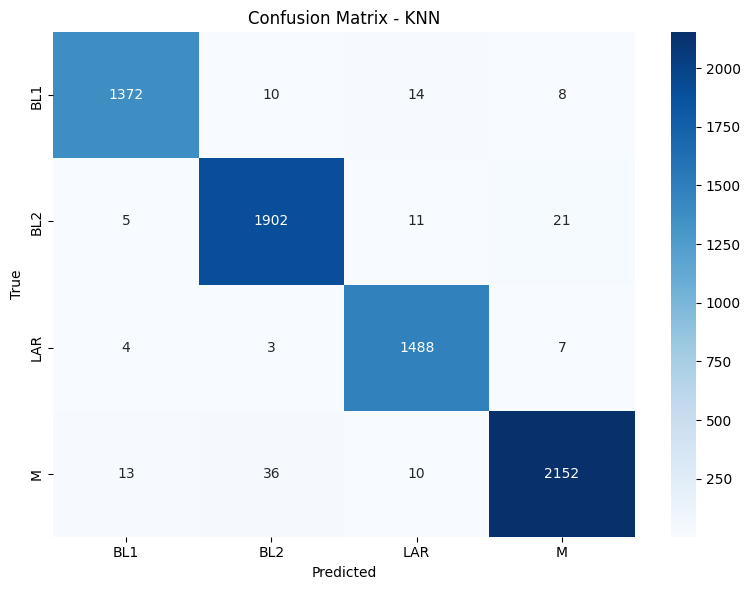

ROC-AUC Score: 0.9977


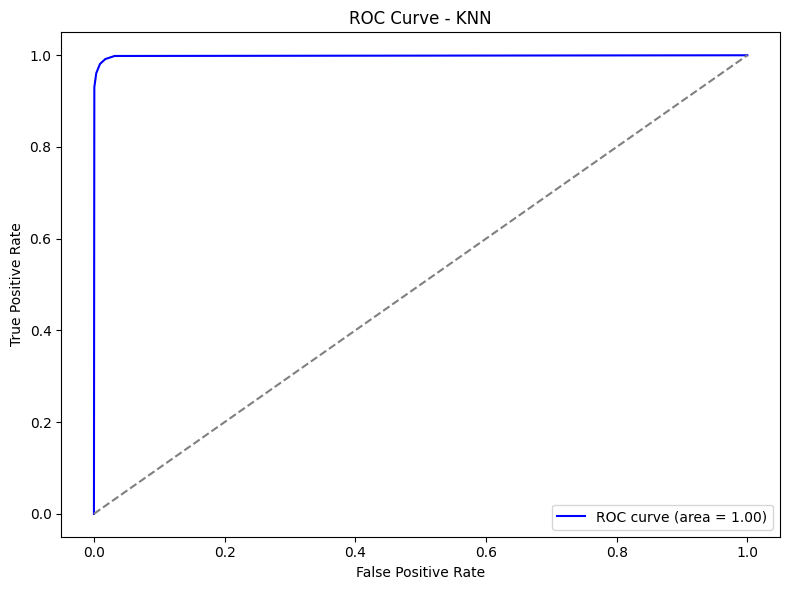

Accuracy: 97.99%

Model: SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1404
           1       0.99      1.00      0.99      1939
           2       0.99      1.00      0.99      1502
           3       1.00      0.99      0.99      2211

    accuracy                           0.99      7056
   macro avg       0.99      0.99      0.99      7056
weighted avg       0.99      0.99      0.99      7056



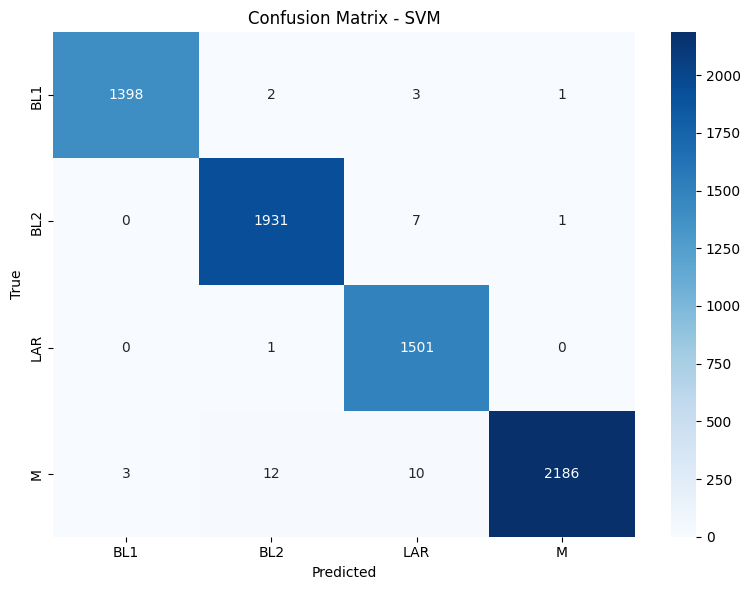

ROC-AUC Score: 1.0000


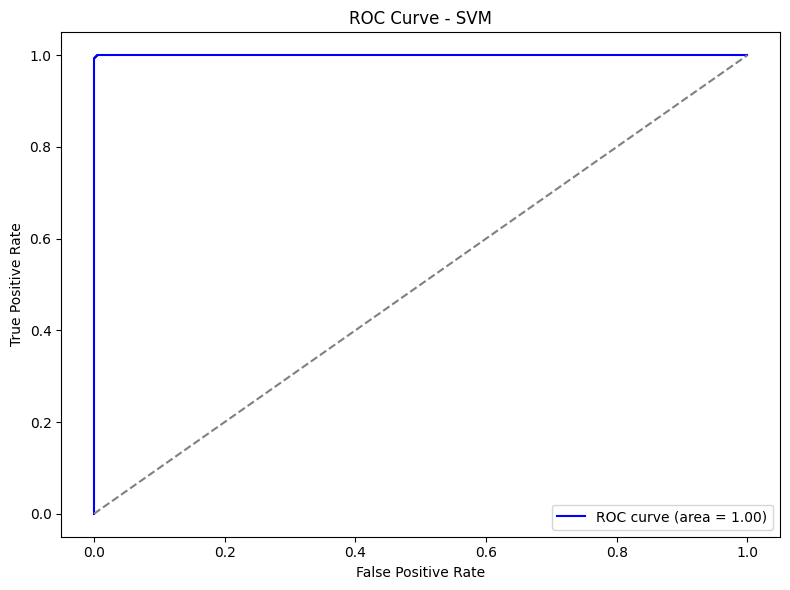

Accuracy: 99.43%

Model: XGBoost
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1404
           1       0.99      0.99      0.99      1939
           2       0.98      0.99      0.99      1502
           3       0.99      0.99      0.99      2211

    accuracy                           0.99      7056
   macro avg       0.99      0.99      0.99      7056
weighted avg       0.99      0.99      0.99      7056



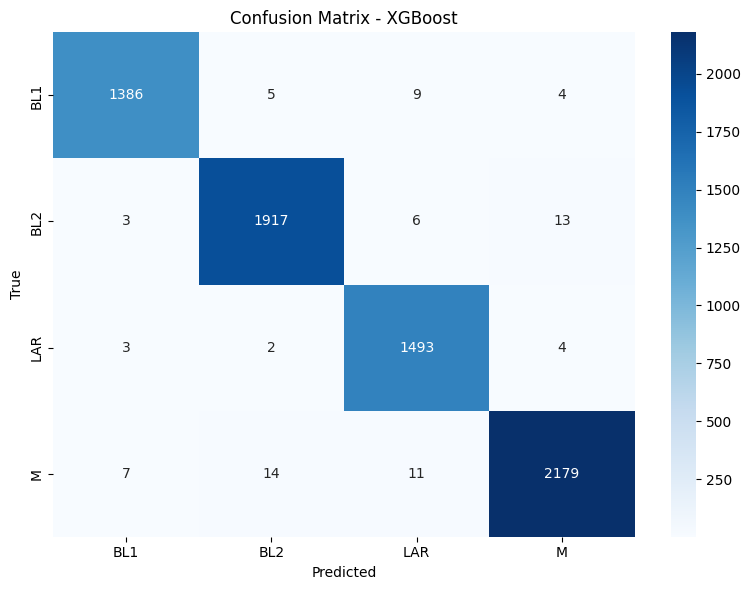

ROC-AUC Score: 0.9998


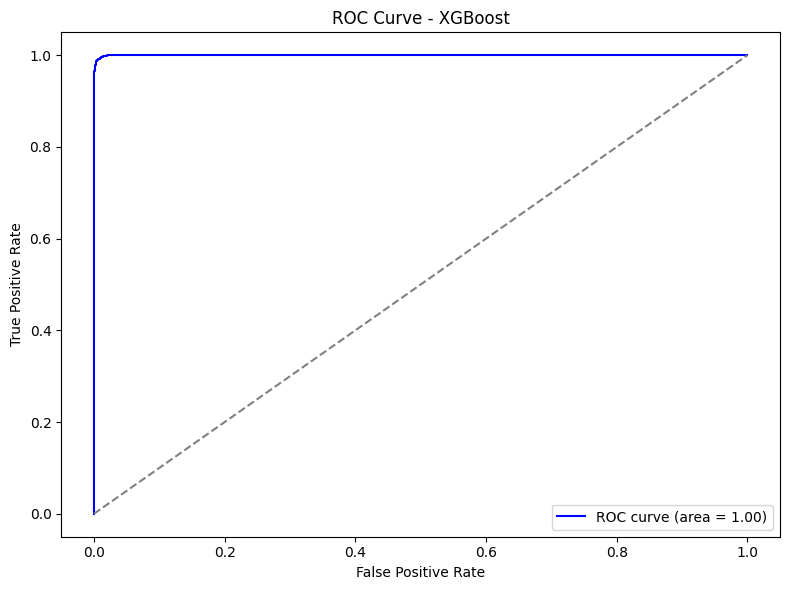

Accuracy: 98.85%

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1404
           1       1.00      1.00      1.00      1939
           2       0.99      1.00      1.00      1502
           3       1.00      0.99      1.00      2211

    accuracy                           1.00      7056
   macro avg       0.99      1.00      1.00      7056
weighted avg       1.00      1.00      1.00      7056



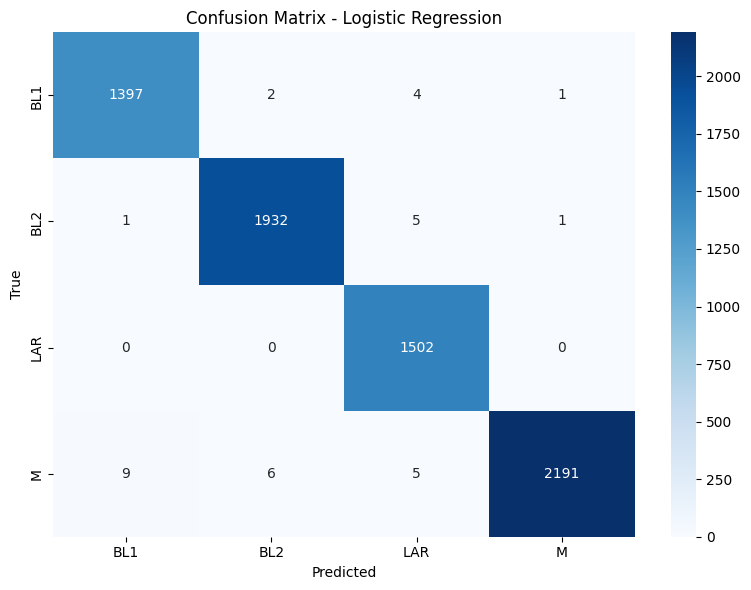

ROC-AUC Score: 1.0000


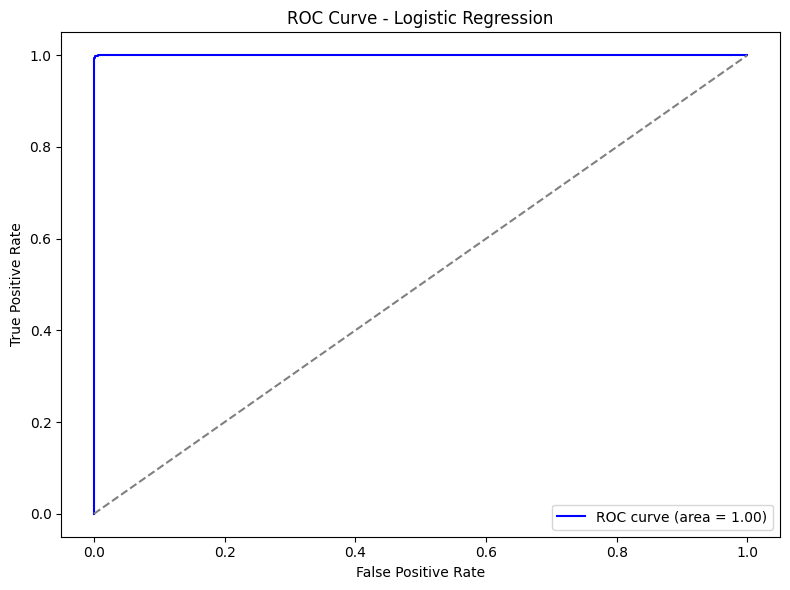

Accuracy: 99.52%
Best Model: Logistic Regression with Accuracy: 99.52%


In [ ]:
#============================
#  Imports
#============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

#============================
# Load and Prepare Data
#============================
df_metabolite = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_umap_training_.csv")
X = df_metabolite.drop(columns=['TNBC_Subtype'])
y = df_metabolite['TNBC_Subtype']

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_labels = le.classes_

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Define Models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

#============================
# Model Evaluation
#============================
best_model = None
best_acc = 0
for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  # For ROC-AUC

    y_pred_labels = le.inverse_transform(y_pred)
    y_true_labels = le.inverse_transform(y_test)

    print(classification_report(y_true_labels, y_pred_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['BL1', 'BL2', 'LAR', 'M'], yticklabels=['BL1', 'BL2', 'LAR', 'M'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC-AUC Metric
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Model Accuracy
    acc = np.mean(y_pred == y_test)
    print(f"Accuracy: {acc * 100:.2f}%")

    if acc > best_acc:
        best_acc = acc
        best_model = (name, model)

print(f"Best Model: {best_model[0]} with Accuracy: {best_acc * 100:.2f}%")

